# LORA Finetuning Demonstration

This notebook demonstrates how to finetune a language model using LORA (Low-Rank Adaptation) on the iambic poem dataset.

In [1]:
!uv pip install transformers torch peft datasets matplotlib seaborn

Using Python 3.11.11 environment at: /SCRATCH/manshri/AIDays-Masterclass/.venv
Audited 6 packages in 86ms


In [2]:
!export NCCL_P2P_DISABLE="1"
!export NCCL_IB_DISABLE="1"
%env NCCL_P2P_DISABLE="1"
%env NCCL_IB_DISABLE="1"

env: NCCL_P2P_DISABLE="1"
env: NCCL_IB_DISABLE="1"


In [3]:
from datasets import Dataset
from transformers import TrainingArguments
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

In [4]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.51.2', '1.6.0')

In [5]:

from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

model.print_trainable_parameters()


We've detected an older driver with an RTX 4000 series GPU. These drivers have issues with P2P. This can affect the multi-gpu inference when using accelerate device_map.Please make sure to update your driver to the latest version which resolves this.


trainable params: 4,956,160 || all params: 1,105,004,544 || trainable%: 0.4485


## Loading and Preparing Data

Let's load the iambic poem dataset and prepare it for training.

In [6]:
# Load the poem data
with open('../iambic_poem.txt', 'r') as f:
    poems = f.readlines()

# Create training dataset
dataset = Dataset.from_dict({"text": poems})

# Load evaluation data
with open('../iambic_eval_data.txt', 'r') as f:
    eval_poems = f.readlines()

# Create evaluation dataset 
eval_dataset = Dataset.from_dict({"text": eval_poems})

# Load model and tokenizer
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

## Setting up LORA

Configure LORA parameters and prepare the model for training.

In [7]:
# LORA configuration
lora_config = LoraConfig(
    r=8,  # rank
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Prepare model for LORA training
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

# Print trainable parameters
model.print_trainable_parameters()

trainable params: 4,956,160 || all params: 1,105,004,544 || trainable%: 0.4485


## Training Setup

Configure the training arguments and prepare the dataset.

In [8]:
# Tokenize dataset
def preprocess_function(examples):
    # Tokenize the texts with padding and truncation
    model_inputs = tokenizer(
        examples["text"],
        padding="max_length",  # Changed to max_length to ensure consistent lengths
        truncation=True,
        max_length=256,  # You can adjust this value based on your needs
        return_tensors=None,  # Important: don't return tensors yet
    )
    
    # Create the labels (for causal language modeling, labels are the same as inputs)
    model_inputs["labels"] = model_inputs["input_ids"].copy()
    
    return model_inputs

# Split the dataset into train and eval
train_test_split = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

# Apply preprocessing to both datasets
tokenized_train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=train_dataset.column_names
)

tokenized_eval_dataset = eval_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=eval_dataset.column_names
)

# Set the format for PyTorch
tokenized_train_dataset.set_format("torch")
tokenized_eval_dataset.set_format("torch")
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    save_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    weight_decay=0.01,
    fp16=True,
    eval_strategy="steps",
    eval_steps=100,
    metric_for_best_model="loss",
    # Add these new arguments
    gradient_accumulation_steps=4,
    warmup_steps=100,
    save_total_limit=3,
    load_best_model_at_end=True,
    
    # Important: Set this to True for causal language modeling
    remove_unused_columns=False,
    label_names=["labels"]
    
)

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
def generate_poem(prompt, max_length=100):
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(
        **inputs.to(model.device),
        max_length=max_length,
        num_return_sequences=1,
        temperature=0.7,
        do_sample=True
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Generate some poems
prompt = "The bright light"
generated_poem = generate_poem(prompt)
print("Generated Poem:")
print(generated_poem)

Generated Poem:
The bright light of the sun

The sun's beams, glowing golden,
Fingers of light, as they touch
The earth below, the land so bright

It is shining, radiant and bright
Like a thousand stars, so bright
The world around, in the sky so bright
With the sun, the world is in its light

The light, so pure and bright,
Illuminates the world with its brilliance


## Visualizing LORA Weights

Let's visualize the LORA weights before and during training.

In [10]:
# Inspect model structure
print("Model structure:")
for name, param in model.named_parameters():
    if "lora" in name.lower():
        print(f"{name}: {param.shape}")

Model structure:
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight: torch.Size([8, 2048])
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight: torch.Size([2048, 8])
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight: torch.Size([8, 2048])
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight: torch.Size([256, 8])
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight: torch.Size([8, 2048])
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight: torch.Size([256, 8])
base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight: torch.Size([8, 2048])
base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight: torch.Size([2048, 8])
base_model.model.model.layers.0.mlp.up_proj.lora_A.default.weight: torch.Size([8, 2048])
base_model.model.model.layers.0.mlp.up_proj.lora_B.default.weight: torch.Size([5632, 8])
base_model.model.model.layers.0.mlp.down_proj.lora_A.de

In [11]:
import matplotlib.pyplot as plt


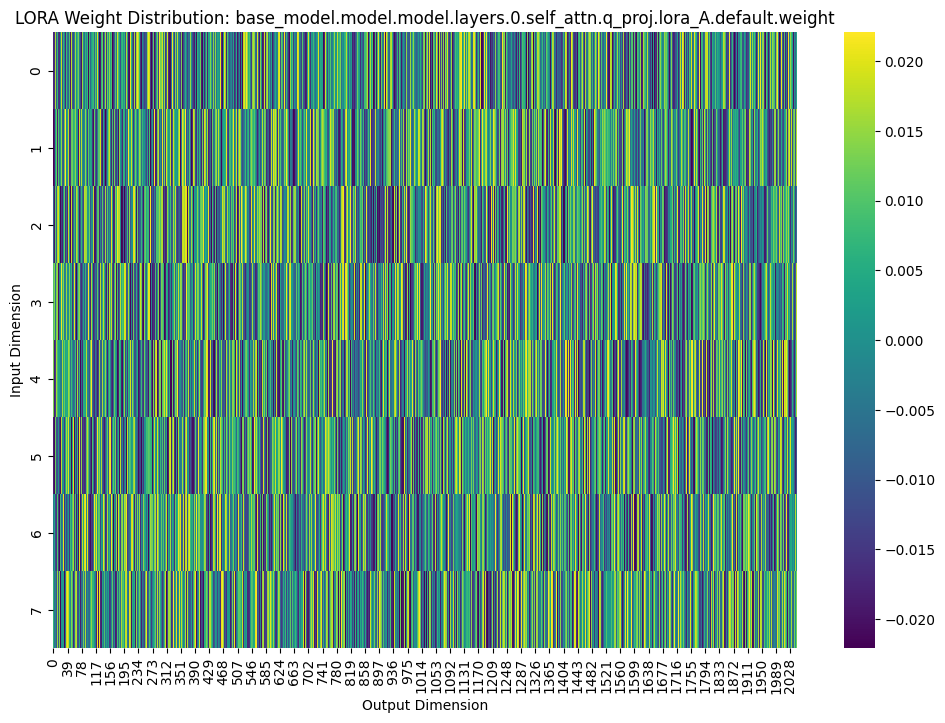

Weight statistics for base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight:
Mean: -0.0001
Std: 0.0128
Min: -0.0221
Max: 0.0221


In [12]:
def plot_lora_weights(model):
    # Find the first LORA layer
    lora_layer = None
    for name, param in model.named_parameters():
        if "lora" in name.lower() and "A" in name:
            lora_layer = name
            break
    
    if lora_layer is None:
        print("No LORA layers found in the model.")
        return
    
    try:
        # Get LORA weights
        lora_weights = model.get_parameter(lora_layer).detach().cpu().numpy()
        
        # Create heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(lora_weights, cmap='viridis', center=0)
        plt.title(f'LORA Weight Distribution: {lora_layer}')
        plt.xlabel('Output Dimension')
        plt.ylabel('Input Dimension')
        plt.show()
        
        # Print statistics
        print(f"Weight statistics for {lora_layer}:")
        print(f"Mean: {lora_weights.mean():.4f}")
        print(f"Std: {lora_weights.std():.4f}")
        print(f"Min: {lora_weights.min():.4f}")
        print(f"Max: {lora_weights.max():.4f}")
    except Exception as e:
        print(f"Error plotting weights: {e}")

# Plot initial LORA weights
plot_lora_weights(model)

## Training Loop with Visualization

Train the model and visualize the LORA weights at different stages.


Epoch 1


Step,Training Loss,Validation Loss
100,0.675300,1.491814
200,0.616200,1.377847
300,0.606100,1.335470
400,0.602500,1.332871
500,0.605100,1.326938
600,0.583300,1.317726
700,0.602700,1.306154
800,0.603800,1.301905


/home/manshri/code/AIDays-Masterclass/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/manshri/code/AIDays-Masterclass/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/manshri/code/AIDays-Masterclass/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/manshri/code/AIDays-Masterclass/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and re

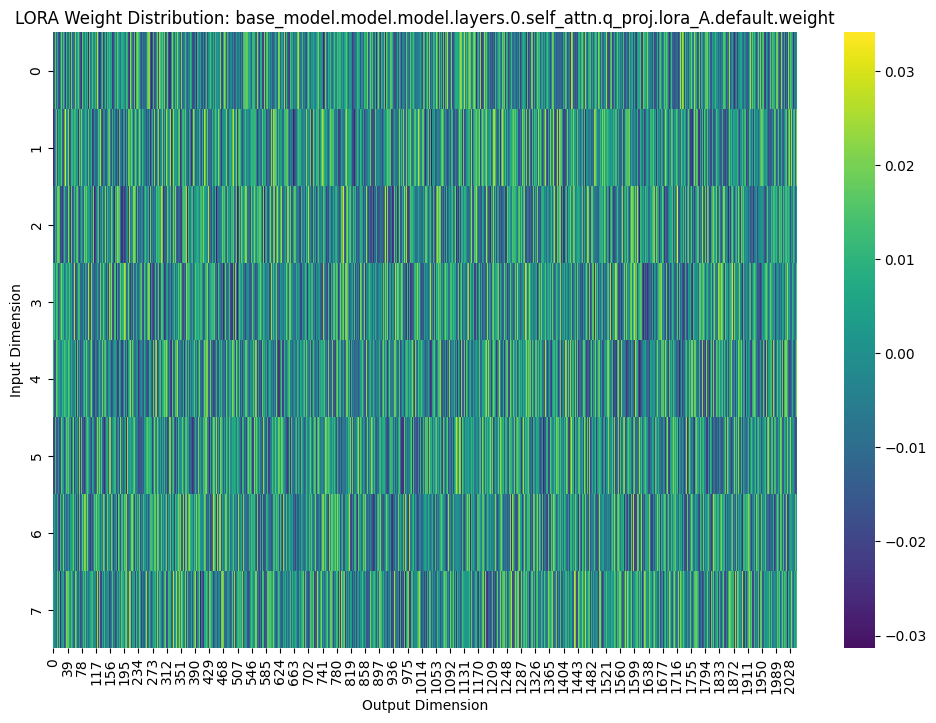

Weight statistics for base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight:
Mean: -0.0001
Std: 0.0132
Min: -0.0314
Max: 0.0341

Epoch 2


Step,Training Loss,Validation Loss
100,0.596900,1.356906
200,0.599300,1.343794
300,0.595600,1.322723
400,0.592700,1.330027
500,0.597400,1.321397
600,0.575700,1.317537
700,0.595200,1.308285
800,0.598700,1.305512


/home/manshri/code/AIDays-Masterclass/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/manshri/code/AIDays-Masterclass/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/manshri/code/AIDays-Masterclass/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/manshri/code/AIDays-Masterclass/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and re

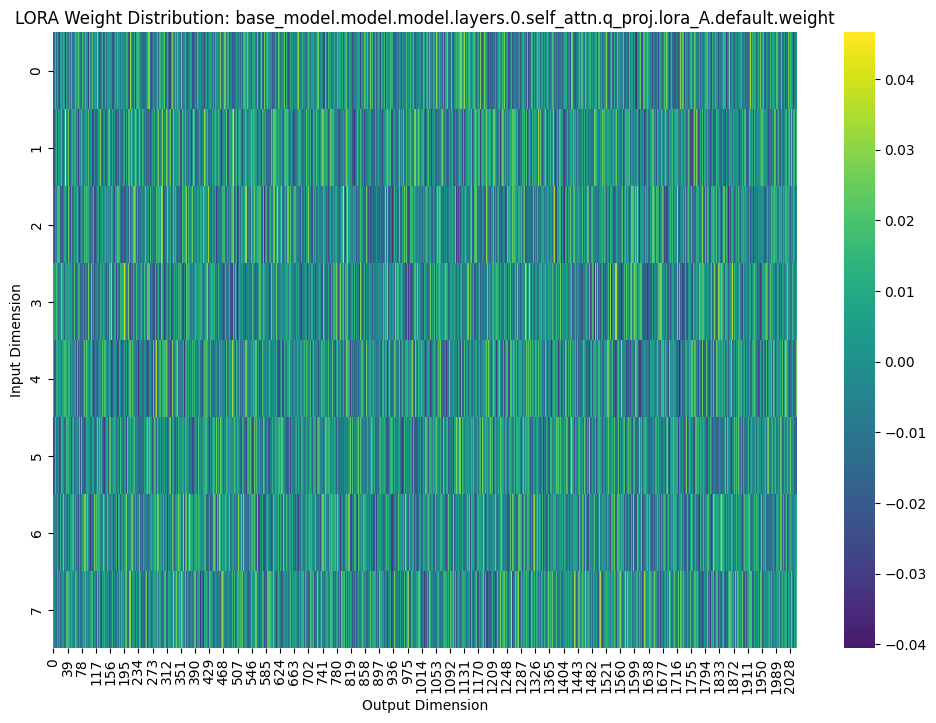

Weight statistics for base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight:
Mean: -0.0002
Std: 0.0143
Min: -0.0405
Max: 0.0466

Epoch 3


Step,Training Loss,Validation Loss
100,0.583200,1.351197
200,0.588300,1.337218
300,0.585900,1.329477
400,0.581600,1.338457
500,0.590300,1.328126
600,0.558200,1.344756
700,0.577600,1.330763
800,0.584900,1.326577


/home/manshri/code/AIDays-Masterclass/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/manshri/code/AIDays-Masterclass/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/manshri/code/AIDays-Masterclass/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/manshri/code/AIDays-Masterclass/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and re

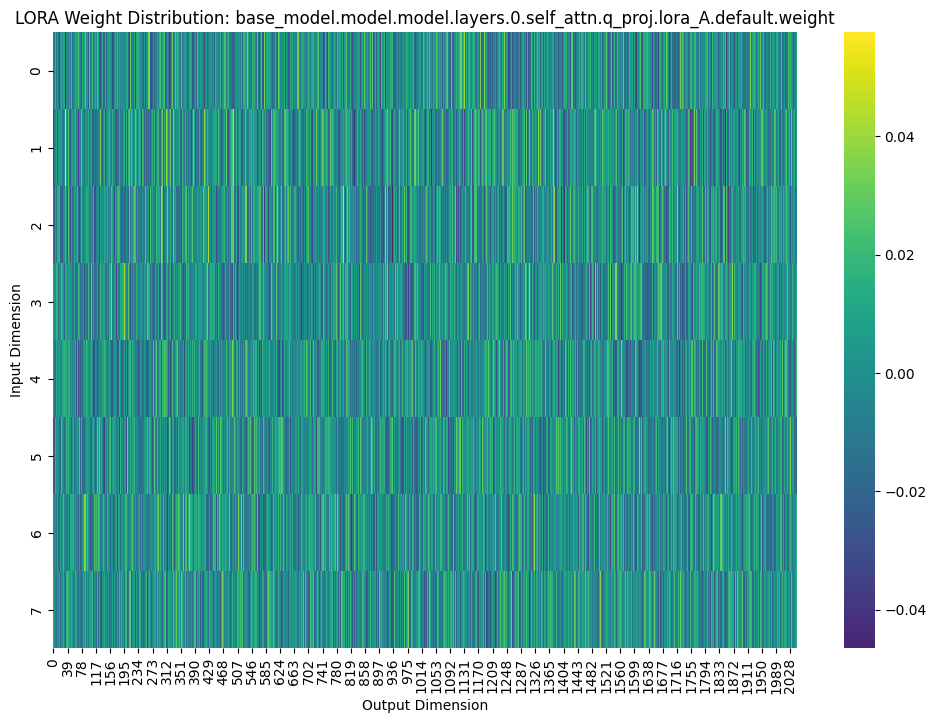

Weight statistics for base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight:
Mean: -0.0002
Std: 0.0154
Min: -0.0465
Max: 0.0576


In [13]:
from transformers import DataCollatorForLanguageModeling
# Create trainer
# Create trainer with proper configuration

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    data_collator=DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False  # Set to False for causal language modeling
    )
)
# Training loop with visualization
for epoch in range(3):
    print(f"\nEpoch {epoch + 1}")
    trainer.train()
    
    # Visualize LORA weights after each epoch
    plot_lora_weights(model)
    
    # Save checkpoint
    trainer.save_model(f"checkpoint-epoch-{epoch+1}")

## Generating Text

Let's test the finetuned model by generating some iambic poetry.

In [14]:


# Generate some poems
prompt = "The bright light"
generated_poem = generate_poem(prompt)
print("Generated Poem:")
print(generated_poem)

Generated Poem:
The bright light runs against the bright light.

As the light rises around the bright light.

The light rises around the bright light.

(Fade the light under the bright light.)

Bright light rises through bright light.

The light rises under the bright light.

(Fade the light under the bright light.)

Light rises under the bright light.

The light moves under the bright light.

